In [1]:
# motion artefacts: ?
# bias: compare to N4ITK and a model we trained for a previous project
# noise: find a denoising algorithm
# super-resolution: evaluate against bilinear interpolation and maybe a machine learning method

In [2]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
from corrupt import corrupt_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage
import random
from gstools import SRF, Gaussian
from scipy.fftpack import dct, idct
import os
from sklearn.metrics import mean_squared_error
from sewar.full_ref import vifp
import time
import SimpleITK as sitk

import warnings
warnings.filterwarnings("ignore")

In [39]:
# data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
# data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"
data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

## Bias: N4ITK

In [28]:
img = corrupt_image(image, "bias")

In [5]:
def bias_correction(img):
    #https://simpleitk.readthedocs.io/en/release/link_N4BiasFieldCorrection_docs.html

    #inputImage = sitk.ReadImage(r"C:\Users\simon\OneDrive - TU Eindhoven\Documents\GitHub\artefacts\figures\bias2.dcm", sitk.sitkFloat32)
    #inputImage = img
    inputImage = sitk.GetImageFromArray(img)
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)

    #image = inputImage

    maskImage = sitk.OtsuThreshold(inputImage, 0, 1, 200)

    corrector = sitk.N4BiasFieldCorrectionImageFilter()

    numberFittingLevels = 4

    corrected_image = corrector.Execute(inputImage, maskImage)

    log_bias_field = corrector.GetLogBiasFieldAsImage(inputImage)

    bias_field = inputImage / sitk.Exp(log_bias_field)

    #castFilter = sitk.CastImageFilter()
    #castFilter.SetOutputPixelType(sitk.sitkInt16)

    #imgFiltered = castFilter.Execute(corrected_image)

    img2 = sitk.GetArrayFromImage(corrected_image)
    #sitk.WriteImage(imgFiltered, r"C:\Users\simon\OneDrive - TU Eindhoven\Documents\GitHub\artefacts\figures\bias_corrected2.dcm")

    img2 = (img2 - np.mean(img2)) / np.std(img2)
    
    return img2

(-0.5, 319.5, 319.5, -0.5)

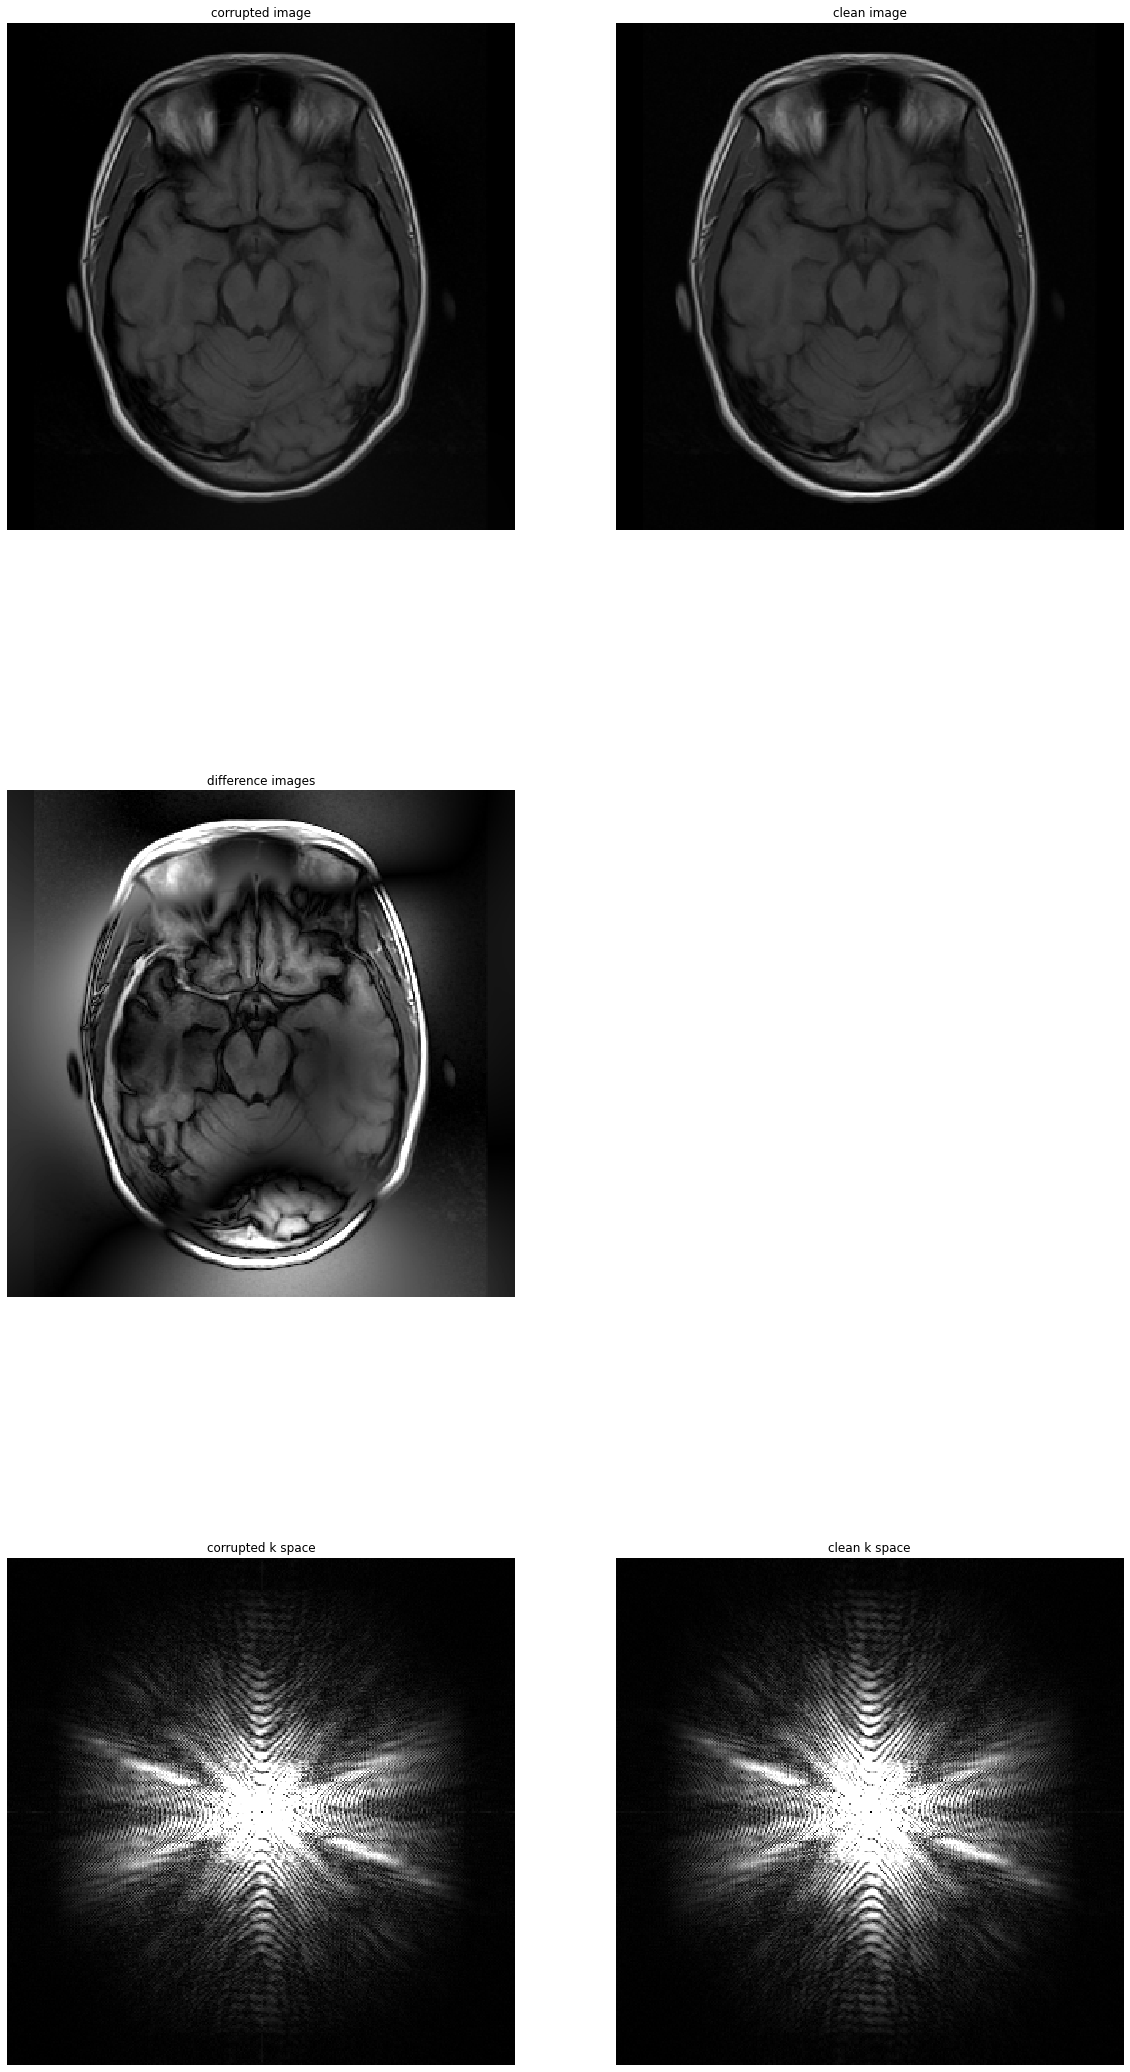

In [6]:
# plotting
img2 = bias_correction(img)

hr = image
lr = img2

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)  #vmin=0.5, vmax=1 / 0.5
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [7]:
print(mean_squared_error(image, img), mean_squared_error(image, img2))

0.0269625478321018 0.03294630118064388


In [8]:
# the artefacts should be well-balanced in terms of MSE

images_path_list = []
#main_path_brain = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM'
#main_path_pelvis = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis2'
main_path_brain = r'C:\from SSD\fastMRI_brain_DICOM'
main_path_pelvis = r'D:\Pelvis_2.2'

folders_brain = os.listdir(main_path_brain)
folders_pelvis = os.listdir(main_path_pelvis)

for folder in folders_brain:
    folder_path = main_path_brain + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)
for folder in folders_pelvis:
    folder_path = main_path_pelvis + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)
print(len(images_path_list))

419615


In [9]:
mse_i = []
mse_f = []

batch = np.arange(len(images_path_list))
np.random.shuffle(batch)
batch = batch[: int((len(images_path_list))/1000)]

for number in batch: 
    image_path = images_path_list[number]
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
        
    if np.max(image) - np.min(image) > 1e-5:
        image = (image - np.mean(image)) / np.std(image)
    
        img_corrupt = corrupt_image(image, "bias")
        img_corrected = bias_correction(img_corrupt)
        
        mse_image_i = mean_squared_error(image, img_corrupt)
        mse_image_f = mean_squared_error(image, img_corrected)
        
        mse_i.append(mse_image_i)
        mse_f.append(mse_image_f)

In [10]:
print(np.mean(mse_i), np.std(mse_i), np.mean(mse_f), np.std(mse_f))
# 0.013005919577735633 0.013640528913424502 0.013612278968729874 0.013190688816177172
# 0.013082336961081213 0.018264668819995823 0.01620880525915458 0.027997321280122302

0.01205561994653474 0.01251112828572897 0.012129098632365365 0.013335179314774457


## Noise: bm3d

In [32]:
import bm3d

In [33]:
img = corrupt_image(image, "noise")
img2 = bm3d.bm3d(img, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.ALL_STAGES) # .HARD_THRESHOLDING
img2 = (img2 - np.mean(img2)) / np.std(img2)

(-0.5, 319.5, 319.5, -0.5)

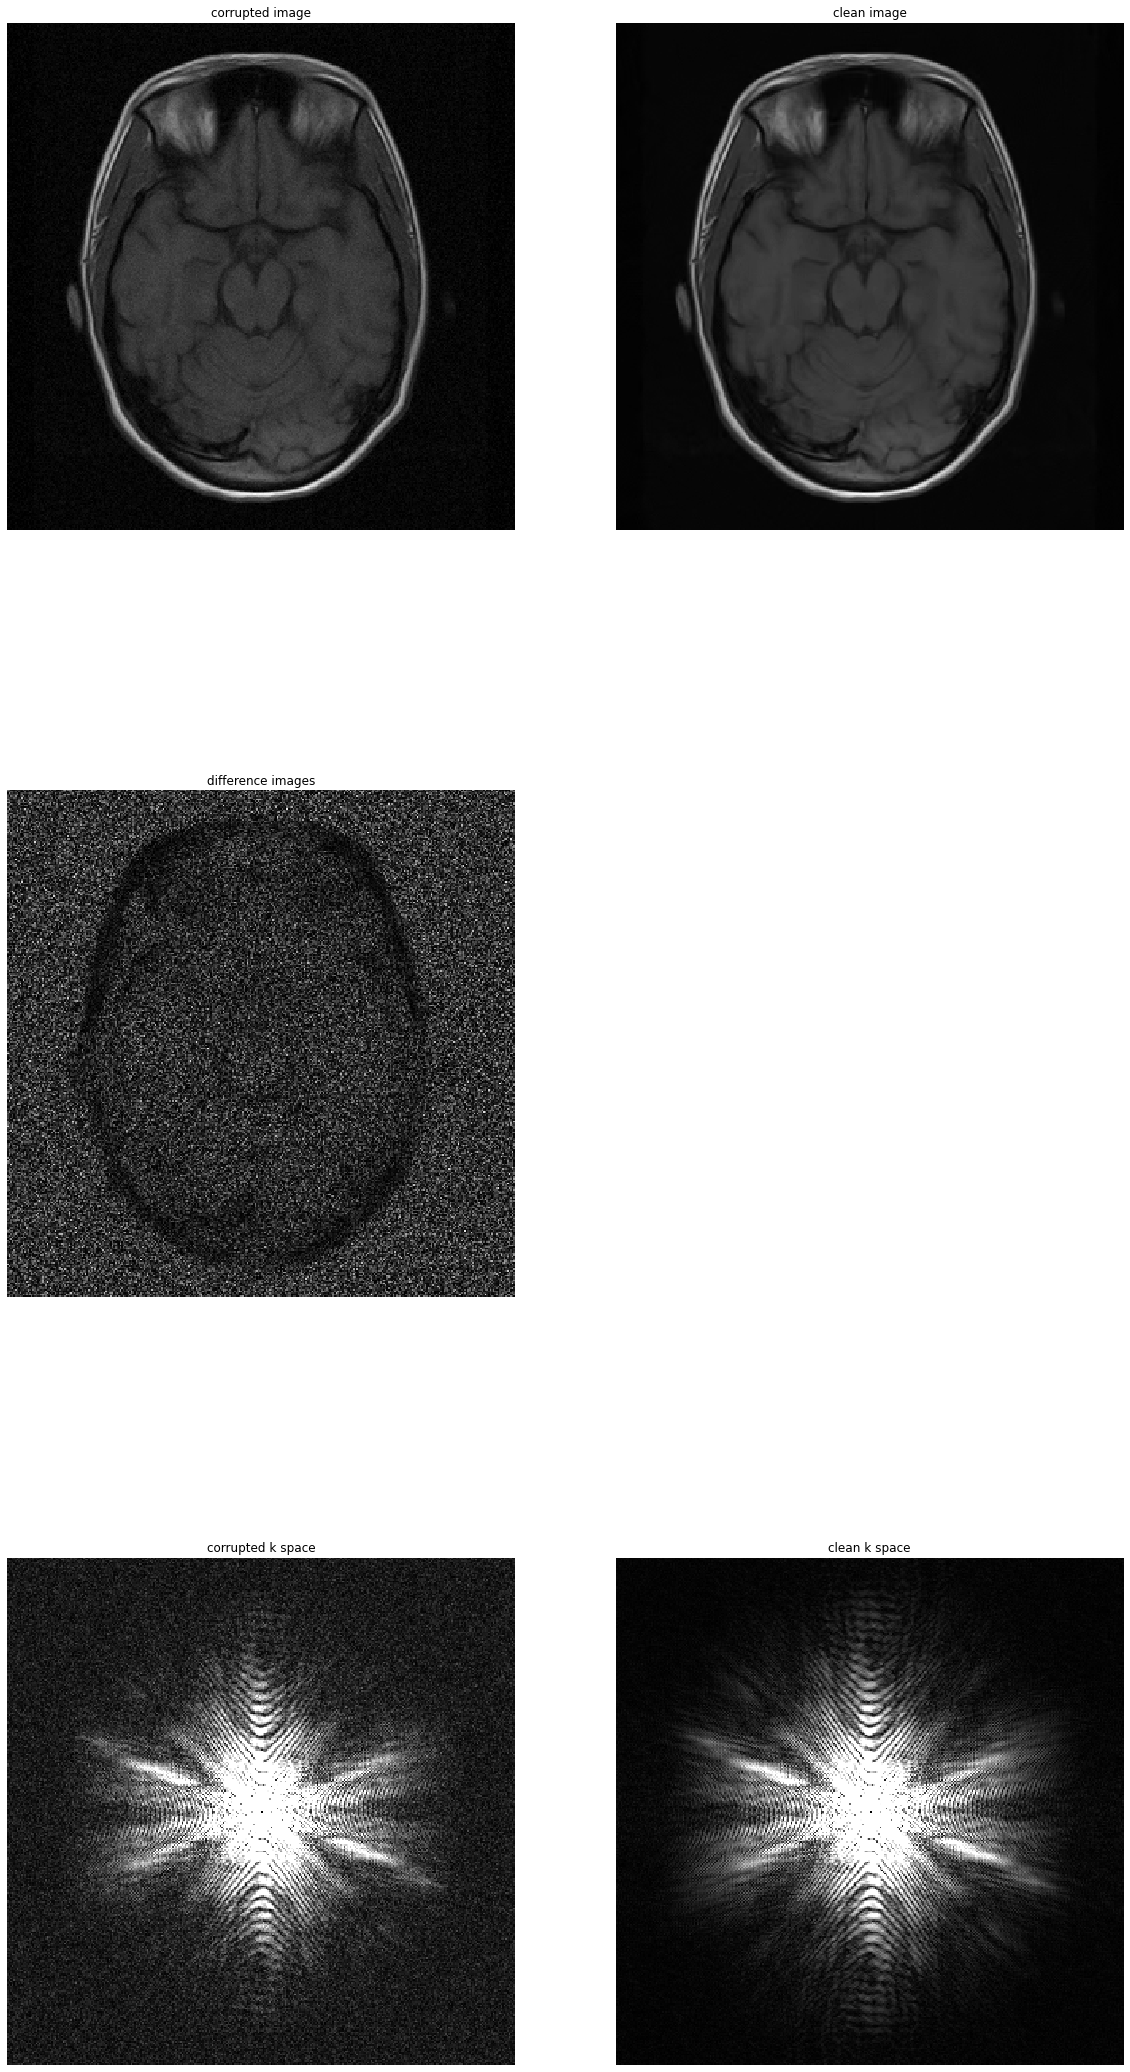

In [34]:
# plotting

hr = img2
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)  #vmin=0.5, vmax=1 / 0.5
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [35]:
print(mean_squared_error(image, img), mean_squared_error(image, img2))

0.018884447565676605 0.003183366335255823


In [36]:
mse_i = []
mse_f = []

batch = np.arange(len(images_path_list))
np.random.shuffle(batch)
batch = batch[: int((len(images_path_list))/10000)]

for number in batch: 
    image_path = images_path_list[number]
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
        
    if np.max(image) - np.min(image) > 1e-5:
        image = (image - np.mean(image)) / np.std(image)
    
        img_corrupt = corrupt_image(image, "noise")
        img_corrected = bm3d.bm3d(img_corrupt, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.ALL_STAGES) # .HARD_THRESHOLDING
        img_corrected = (img_corrected - np.mean(img_corrected)) / np.std(img_corrected)
        
        mse_image_i = mean_squared_error(image, img_corrupt)
        mse_image_f = mean_squared_error(image, img_corrected)
        
        mse_i.append(mse_image_i)
        mse_f.append(mse_image_f)

In [37]:
print(np.mean(mse_i), np.std(mse_i), np.mean(mse_f), np.std(mse_f))
# 0.014259325245710039 0.01679204781189589 0.00517145123531542 0.014150941723141058
# 0.015660292683515115 0.014206572785518498 0.006087129434883038 0.010224181323470886

0.015660292683515115 0.014206572785518498 0.006087129434883038 0.010224181323470886


## Super resolution: bilinear interpolation

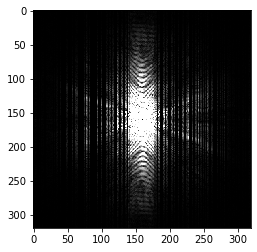

In [71]:
img = corrupt_image(image, "downsample")
k = transform_image_to_kspace(img)
kspace = np.abs(k) / np.max(np.abs(k))
plt.imshow(kspace, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)

In [74]:
np.where(np.abs(k) < (1e-10))

(array([  0,   0,   0, ..., 319, 319, 319], dtype=int64),
 array([  0,   6,   7, ..., 312, 313, 314], dtype=int64))

In [75]:
k2 = np.where(np.abs(k) < (1e-10), np.nan, k)

In [76]:
k2

array([[        nan+0.00000000e+00j,  0.00145436-4.78367053e-03j,
         0.00064288-7.16865353e-05j, ..., -0.0021118 -5.33560405e-03j,
         0.00064288+7.16865353e-05j,  0.00145436+4.78367053e-03j],
       [        nan+0.00000000e+00j, -0.00076065+3.58274330e-05j,
        -0.00150826+8.39985060e-05j, ..., -0.00246275+4.58980919e-03j,
        -0.00088641-8.60252341e-04j, -0.00138535-1.28000462e-03j],
       [        nan+0.00000000e+00j,  0.00108455+4.35971920e-03j,
        -0.00246103-1.21194578e-03j, ..., -0.00195285+2.07945880e-03j,
         0.00359623-2.36270753e-03j, -0.00192639-4.50310200e-03j],
       ...,
       [        nan+0.00000000e+00j,  0.00122073-4.54864432e-03j,
        -0.00163969-3.51634333e-03j, ...,  0.00240178-7.97868104e-03j,
         0.00095846-1.96586294e-03j, -0.00013512+4.33141332e-03j],
       [        nan+0.00000000e+00j, -0.00192639+4.50310200e-03j,
         0.00359623+2.36270753e-03j, ...,  0.00787735+7.97490122e-03j,
        -0.00246103+1.21194578e-03j